In [1]:
import torch
import gc
import torchvision.models as models
import torch.nn as nn
from torchsummary import summary

import dataloader as defencer

In [2]:
%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


In [3]:
# Free cuda memory
# Reference: https://discuss.pytorch.org/t/how-to-debug-causes-of-gpu-memory-leaks/6741/13
def freemem():
    for obj in gc.get_objects():
        if torch.is_tensor(obj) and torch.is_tensor(obj.data):
            del obj
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

Image train=67581, Fence train=18
Image val=8448, Fence val=9
Image test=8448, Fence test=3


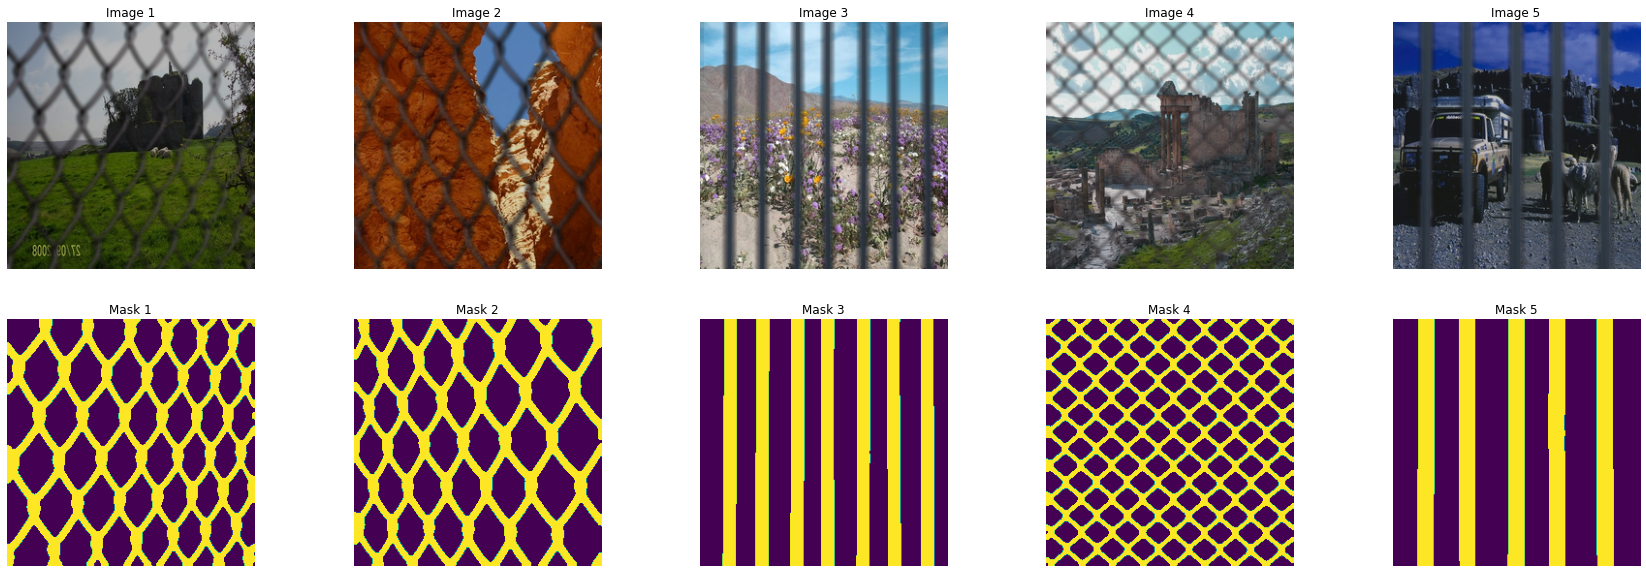

In [4]:
loader_train, loader_val, loader_test = defencer.Get_DataLoaders(16, 4)

In [5]:
resnet50 = models.resnet50(pretrained=True)
x, y = next(iter(loader_val))
resnet50.fc = nn.Linear(2048, 65536)

for param in resnet50.parameters():
    param.require_grad = False
resnet50.fc.requires_grad_(True)

Linear(in_features=2048, out_features=65536, bias=True)

In [6]:
freemem()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
resnet50 = resnet50.to(device)
summary(resnet50, (3, 256, 256))

c:\Users\EthanRuoff\anaconda3\envs\cv\lib\site-packages\torch\distributed\distributed_c10d.py:170: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


Device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14      

In [7]:
from segmentation_model import trainer
from segmentation_model import evaluator
from segmentation_model import visualizer

In [8]:
val_loss_hist, val_acc_hist = trainer.train(resnet50, loader_train, loader_val, lr=1e-3, device=device, num_epochs=100, patience=10, pos_weight=[3])

Training epoch 1 batch 2111/4223, train loss = 1.001249, train acc = 0.492852, recall = 0.892832, precision = 0.386501
validation metrics at epoch 1 batch 2111: val loss = 0.766058, val acc = 0.606133, val recall = 0.932588, val precision = 0.423116
Training epoch 1 batch 4222/4223, train loss = 0.899735, train acc = 0.562877, recall = 0.893135, precision = 0.428390
validation metrics at epoch 1 batch 4222: val loss = 0.743785, val acc = 0.618497, val recall = 0.935528, val precision = 0.434207
Training epoch 1 batch 4223/4223, train loss = 0.899718, train acc = 0.562893, recall = 0.893134, precision = 0.428396
validation metrics at epoch 1 batch 4223: val loss = 0.750428, val acc = 0.608974, val recall = 0.939414, val precision = 0.428285
current_patience = 9
Epoch 1/100 train loss = 0.899718, train acc = 0.562893, val loss = 0.750428, val acc = 0.608974
Training epoch 2 batch 2111/4223, train loss = 0.758378, train acc = 0.654817, recall = 0.896899, precision = 0.488540
validation me

In [9]:
for param in resnet50.parameters():
    param.require_grad = True
val_loss_hist, val_acc_hist = trainer.train(resnet50, loader_train, loader_val, lr=1e-3, device=device, num_epochs=100, patience=10)

torch.save(resnet50.state_dict(), 'saved_models/resnet50.model')

Training epoch 1 batch 2111/4223, train loss = 0.215041, train acc = 0.894731, recall = 0.805018, precision = 0.861583
validation metrics at epoch 1 batch 2111: val loss = 0.298207, val acc = 0.869587, val recall = 0.726232, val precision = 0.809351
Training epoch 1 batch 4222/4223, train loss = 0.209727, train acc = 0.897757, recall = 0.811742, precision = 0.865586
validation metrics at epoch 1 batch 4222: val loss = 0.292875, val acc = 0.878923, val recall = 0.747076, val precision = 0.823730
Training epoch 1 batch 4223/4223, train loss = 0.209703, train acc = 0.897771, recall = 0.811771, precision = 0.865603
validation metrics at epoch 1 batch 4223: val loss = 0.285499, val acc = 0.880796, val recall = 0.750846, val precision = 0.826755
Epoch 1/100 train loss = 0.209703, train acc = 0.897771, val loss = 0.285499, val acc = 0.880796
Training epoch 2 batch 2111/4223, train loss = 0.194405, train acc = 0.906552, recall = 0.832672, precision = 0.874556
validation metrics at epoch 2 batc

Accuracy = 92.32187271118164%
Precision = 85.89226603507996%
Recall = 86.40948534011841%


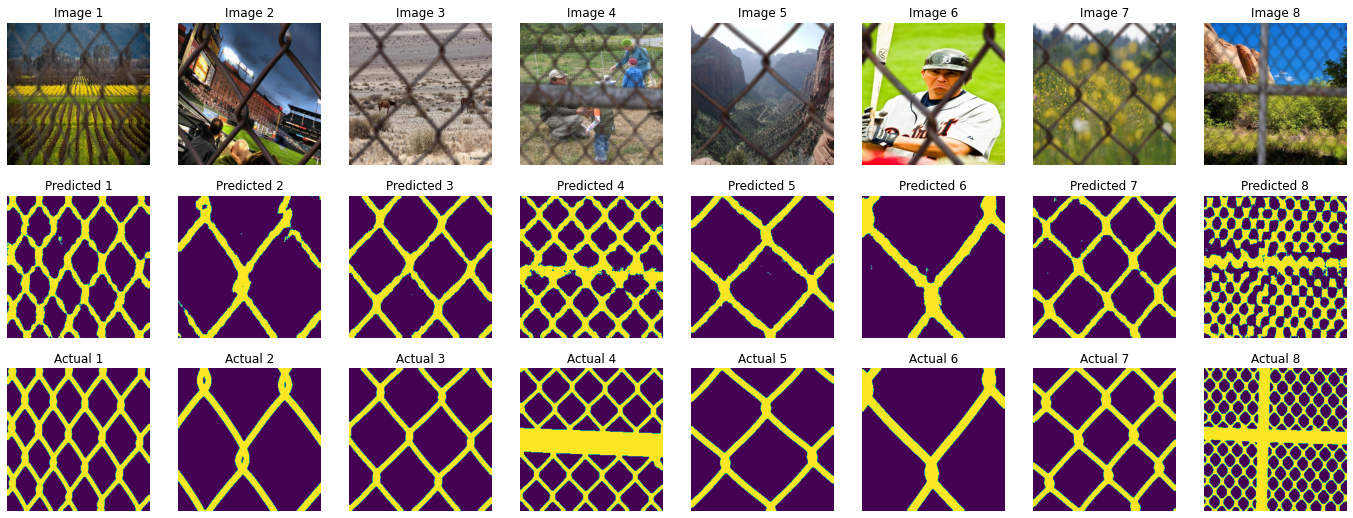

In [14]:
visualizer.visualize_model_output(loader_test, resnet50, device=device)